In [ ]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib


In [ ]:
# Reading the data
dft = Table.read('/home/samanehjavadinia/Co-op/Data/ngvs_matched.fits')


In [ ]:
dft.columns

In [ ]:
dft = dft[['ngvsID','x_sex','y_sex','ra_in','dec_in','elongation','umag','gmag','rmag','imag','zmag','ksmag','uerr'
           ,'gerr','rerr','ierr','zerr','kserr','iC','iCerr','ebv',  
           'field','background_g','ug0','gi0','iz0','ik0','p_star','p_gc','p_galx',
'main_type','other_types']].to_pandas()


In [ ]:
# Apply the transformations to all columns
dft = dft.applymap(lambda x: x.decode('UTF-8').strip().upper() if isinstance(x, bytes) else x)

In [ ]:
dft = dft.drop(columns=['ngvsID','field','x_sex','y_sex','ra_in','dec_in', 'other_types'])

In [ ]:
dft.head()

In [ ]:
dft.columns

In [ ]:
dft.shape

In [ ]:
dft_cleaned = dft.dropna(subset=['main_type'])
unlabeled_data = dft[dft['main_type'].isna()]

In [ ]:
dft_cleaned.shape

In [ ]:
unlabeled_data.shape

In [ ]:
unlabeled_data = unlabeled_data.copy()

In [ ]:
dft = dft_cleaned.copy()

In [ ]:
pd.set_option('display.max_columns', None)
dft.describe()

In [ ]:
dft['main_type'].value_counts()

In [ ]:
# Setting the max rows option to display all rows
pd.set_option('display.max_rows', None)
dft['main_type'].value_counts()

In [ ]:
# Create and display the pie chart of the new column
category_counts = dft['main_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Count the occurrences of each category
category_counts = dft['main_type'].value_counts()

# Specify the categorical column
category_column = 'main_type'

# Define the threshold for rare categories
threshold = 300  # Categories with counts less than or equal to this will be grouped into "Other"

# Count the occurrences of each category
category_counts = dft[category_column].value_counts()

# Identify the rare categories
rare_categories = category_counts[category_counts <= threshold].index

# Create a new column with grouped categories
dft['grouped_category'] = dft[category_column].apply(lambda x: 'Other' if x in rare_categories else x)

# Print the number of different categories in the new column
num_categories = dft['grouped_category'].nunique()
print(f'The number of different categories in the new grouped column: {num_categories}')



# Count the occurrences of each category
category_counts = dft['grouped_category'].value_counts()


# Create and display the pie chart of the new column
category_counts = dft['grouped_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Grouped Categories')
plt.show()

In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
dft['grouped_category'].value_counts()

In [ ]:
dft.columns

In [ ]:
dft = dft.drop(columns='main_type')

In [ ]:
# Get the unique types in the 'grouped_category' column
unique_types = dft['grouped_category'].apply(type).unique()
print("Different types in 'grouped_category' column:", unique_types)

In [ ]:
# Ensure all values in 'grouped_category' are strings
dft['grouped_category'] = dft['grouped_category'].astype(str)

In [ ]:
df = dft.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoder = LabelEncoder()
df['main_type_encoded'] = label_encoder.fit_transform(df['grouped_category'])

# Save the encoder to disk
joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
df.columns

In [ ]:
 # Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlations of the features with the target
correlation_with_target = correlation_matrix['main_type_encoded'].drop('main_type_encoded')


# Sort correlations
sorted_correlations = correlation_with_target.sort_values()

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette="viridis")
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = [ 'umag', 'gmag', 'imag', 'zmag',
       'uerr', 'gerr', 'ierr', 'zerr', 'iC', 'iCerr', 'ebv', 'background_g',
       'ug0', 'gi0', 'iz0', 'main_type_encoded']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

In [ ]:
# df = df.drop(columns=[ 'elongation','ik0' , 'ksmag', 'kserr', 'rmag', 'rerr', 'p_galx', 'p_star', 'p_gc', 'grouped_category'])
df = df.drop(columns=[ 'p_galx', 'p_star', 'p_gc', 'grouped_category'])

In [ ]:
unlabeled_data.columns

In [ ]:
unlabeled_data['main_type'].value_counts()

In [ ]:
unlabeled_data = unlabeled_data.drop(columns=[ 'p_galx', 'p_star', 'p_gc','main_type'])

In [ ]:
unlabeled_data.columns

In [ ]:
from tabulate import tabulate

# Print the DataFrame columns in a tabulated format
columns = df.columns.tolist()
print(tabulate([[col] for col in columns], headers=['Columns'], tablefmt='grid'))

In [ ]:
# Save the train and test datasets to CSV files
df.to_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv', index=False)
unlabeled_data.to_csv('/home/samanehjavadinia/Co-op/Data/unlabeled_data.csv', index=False)

#############LOading
###########
#######
#########
#########


In [1]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib

In [2]:
# If you want to load the data later, you can use the following code
df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv')
unlabeled_data = pd.read_csv('/home/samanehjavadinia/Co-op/Data/unlabeled_data.csv')
# Load the encoder from disk
label_encoder = joblib.load('label_encoder.pkl')


In [3]:
df.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'main_type_encoded'],
      dtype='object')

In [54]:
# Function to get the value counts of columns with fewer than 5 unique values
def print_columns_with_fewer_than_5_unique_values(df):
    for column in df.columns:
        unique_values_count = df[column].nunique()
        if unique_values_count < 5:
            print(f"Value counts for column '{column}' (unique values: {unique_values_count}):")
            print(df[column].value_counts())
            print("\n")

# Assuming df is your DataFrame
print_columns_with_fewer_than_5_unique_values(df)

Value counts for column 'elongation' (unique values: 1):
0.0    23524
Name: elongation, dtype: int64


Value counts for column 'ksmag' (unique values: 1):
99.0    23524
Name: ksmag, dtype: int64


Value counts for column 'kserr' (unique values: 1):
99.0    23524
Name: kserr, dtype: int64


Value counts for column 'ik0' (unique values: 1):
99.0    23524
Name: ik0, dtype: int64




In [55]:
# Assuming df is your DataFrame
print_columns_with_fewer_than_5_unique_values(unlabeled_data)

Value counts for column 'elongation' (unique values: 1):
0.0    4473252
Name: elongation, dtype: int64


Value counts for column 'ksmag' (unique values: 1):
99.0    4473252
Name: ksmag, dtype: int64


Value counts for column 'kserr' (unique values: 1):
99.0    4473252
Name: kserr, dtype: int64


Value counts for column 'ik0' (unique values: 1):
99.0    4473252
Name: ik0, dtype: int64




In [48]:
unlabeled_data.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'umag_gmag', 'imag_zmag',
       'umag_gmag_bin', 'imag_zmag_bin'],
      dtype='object')

In [4]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)
# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']

In [5]:
X_train.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,...,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0
12720,0.0,23.099199,21.361099,99.0000,19.529800,19.214701,99.0,0.01965,0.00345,0.00000,...,0.00315,99.0,0.3386,0.003445,0.018,0.610521,1.721378,1.802806,0.306406,99.0
1662,0.0,19.687000,18.801800,99.0000,18.363400,18.289000,99.0,0.00225,0.00090,0.00000,...,0.00180,99.0,0.0104,0.002621,0.027,0.180993,0.860117,0.395659,0.061359,99.0
4351,0.0,20.954300,20.351700,99.0000,19.963200,19.931000,99.0,0.00420,0.00195,0.00000,...,0.00585,99.0,0.0164,0.006954,0.022,0.078900,0.582162,0.353674,0.021574,99.0
13246,0.0,23.454700,22.315100,21.8036,21.532499,21.361500,99.0,0.02265,0.00615,0.00630,...,0.01665,99.0,0.1596,0.019230,0.024,1.598970,1.117304,0.744608,0.159408,99.0
9664,0.0,25.041000,23.950600,99.0000,23.100000,22.928499,99.0,0.11100,0.03255,0.04245,...,0.09480,99.0,0.1133,0.093398,0.022,15.291100,1.069962,0.815774,0.160874,99.0


In [6]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numeric_columns(train_df, test_df):
    # Identify non-numeric and numeric columns
    non_numeric_columns = train_df.select_dtypes(include=['object']).columns
    numeric_columns = train_df.select_dtypes(exclude=['object']).columns

    # Separate non-numeric and numeric columns
    train_non_numeric = train_df[non_numeric_columns]
    train_numeric = train_df[numeric_columns]

    test_non_numeric = test_df[non_numeric_columns]
    test_numeric = test_df[numeric_columns]

    # Handle missing values in numeric columns
    train_numeric = train_numeric.dropna()
    test_numeric = test_numeric.dropna()
    # Alternatively, fill missing values
    # train_numeric = train_numeric.fillna(train_numeric.mean())
    # test_numeric = test_numeric.fillna(test_numeric.mean())

    # Scale the numeric columns
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled = scaler.transform(test_numeric)

    # Convert the scaled array back to DataFrames
    train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_columns)
    test_numeric_scaled = pd.DataFrame(test_numeric_scaled, columns=numeric_columns)

    # Combine the scaled numeric columns with the non-numeric columns
    train_scaled = pd.concat([train_numeric_scaled, train_non_numeric.reset_index(drop=True)], axis=1)
    test_scaled = pd.concat([test_numeric_scaled, test_non_numeric.reset_index(drop=True)], axis=1)

    return train_scaled, test_scaled

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
X_train_scaled, X_test_scaled = scale_numeric_columns(X_train, X_test)
# print("Scaled train data:", X_train_scaled.head())
# print("Scaled test data:", X_test_scaled.head())


In [7]:
X_train.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,...,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0
12720,0.0,23.099199,21.361099,99.0000,19.529800,19.214701,99.0,0.01965,0.00345,0.00000,...,0.00315,99.0,0.3386,0.003445,0.018,0.610521,1.721378,1.802806,0.306406,99.0
1662,0.0,19.687000,18.801800,99.0000,18.363400,18.289000,99.0,0.00225,0.00090,0.00000,...,0.00180,99.0,0.0104,0.002621,0.027,0.180993,0.860117,0.395659,0.061359,99.0
4351,0.0,20.954300,20.351700,99.0000,19.963200,19.931000,99.0,0.00420,0.00195,0.00000,...,0.00585,99.0,0.0164,0.006954,0.022,0.078900,0.582162,0.353674,0.021574,99.0
13246,0.0,23.454700,22.315100,21.8036,21.532499,21.361500,99.0,0.02265,0.00615,0.00630,...,0.01665,99.0,0.1596,0.019230,0.024,1.598970,1.117304,0.744608,0.159408,99.0
9664,0.0,25.041000,23.950600,99.0000,23.100000,22.928499,99.0,0.11100,0.03255,0.04245,...,0.09480,99.0,0.1133,0.093398,0.022,15.291100,1.069962,0.815774,0.160874,99.0


########### Training on XGBoost
############
############
###########
###########

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29        77
           1       0.62      0.59      0.61       669
           2       0.71      0.83      0.76       596
           3       0.76      0.84      0.80       914
           4       0.72      0.72      0.72       676
           5       0.54      0.32      0.40       411
           6       0.80      0.89      0.84       653
           7       0.80      0.81      0.80       548
           8       0.54      0.49      0.51        89
           9       0.33      0.12      0.18        72

    accuracy                           0.72      4705
   macro avg       0.62      0.58      0.59      4705
weighted avg       0.70      0.72      0.70      4705

Label Mapping: {'BCLG': 0, 'GALAXY': 1, 'GINCL': 2, 'GLCL': 3, 'GLCL?_CANDIDATE': 4, 'Other': 5, 'QSO': 6, 'STAR': 7, 'WD*_CANDIDATE': 8, 'X': 9}
['BCLG', 'GALAXY', 'GINCL', 'GLCL', 'GLCL?_CANDIDATE', 'O

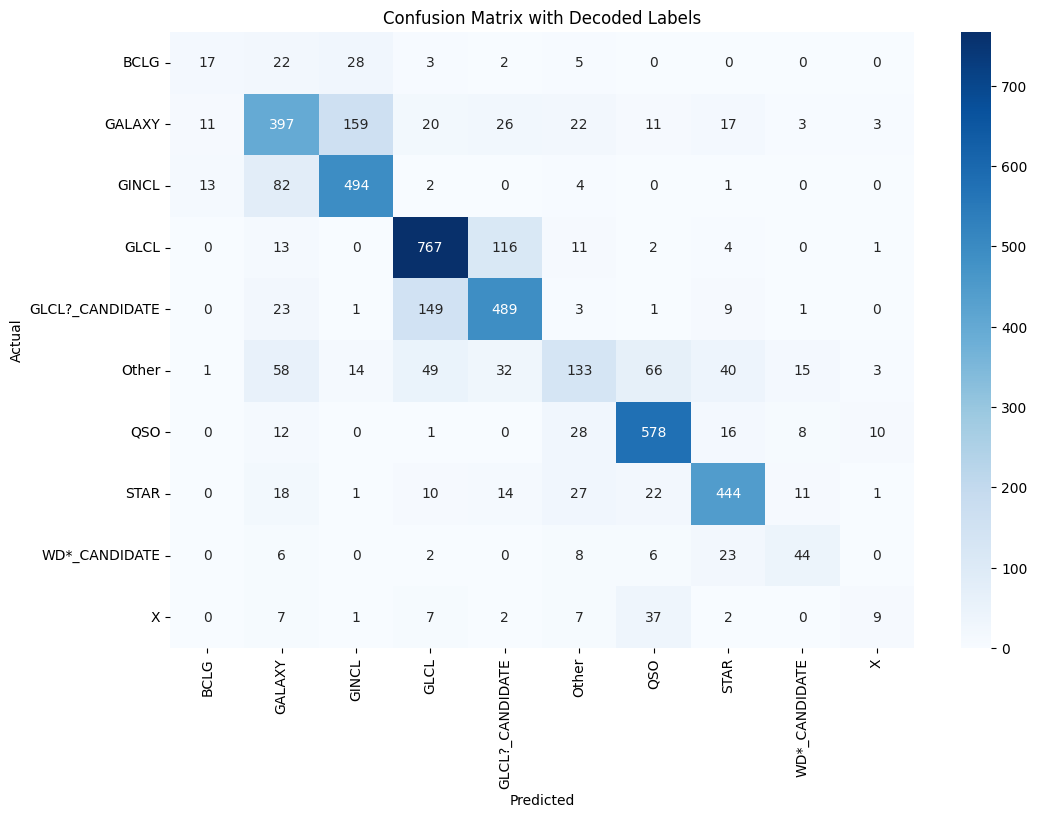

Model saved to xgboost_model.pkl


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import xgboost as xgb
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [9]:
# Get the index of the label 'GLCL'
glcl_index = label_mapping["GLCL"]

# Extract the row and column corresponding to 'GLCL' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'GLCL'
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



Number of correct predictions for label GLCL: 767
Number of false predictions for label GLCL: 390
Accuracy for label GLCL: 0.92


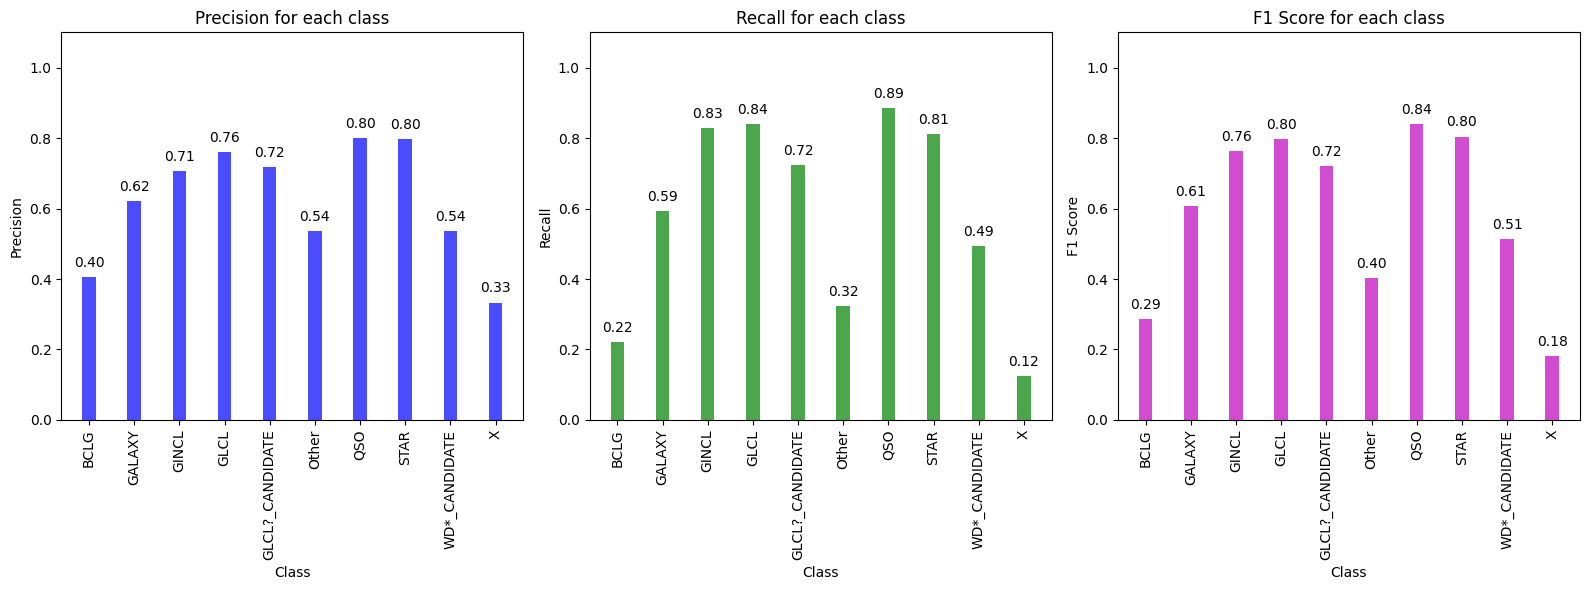

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
num_classes = conf_matrix.shape[0]

# Initialize lists to store precision, recall, and f1 score for each label
precisions = []
recalls = []
f1_scores = []



# Calculate precision, recall, and f1 score for each class
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each class
labels = list(label_mapping.keys())
x = np.arange(len(labels))
bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()


###########Training on xgboost with binary classification#########

In [11]:
y_train.value_counts()

3    3654
4    2705
1    2677
6    2611
2    2384
7    2194
5    1645
8     356
0     306
9     287
Name: main_type_encoded, dtype: int64

In [12]:
y_test.value_counts()

3    914
4    676
1    669
6    653
2    596
7    548
5    411
8     89
0     77
9     72
Name: main_type_encoded, dtype: int64

In [13]:
X_train.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0'],
      dtype='object')

Optimal Threshold: 0.39
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3791
           1       0.76      0.85      0.80       914

    accuracy                           0.92      4705
   macro avg       0.86      0.89      0.88      4705
weighted avg       0.92      0.92      0.92      4705



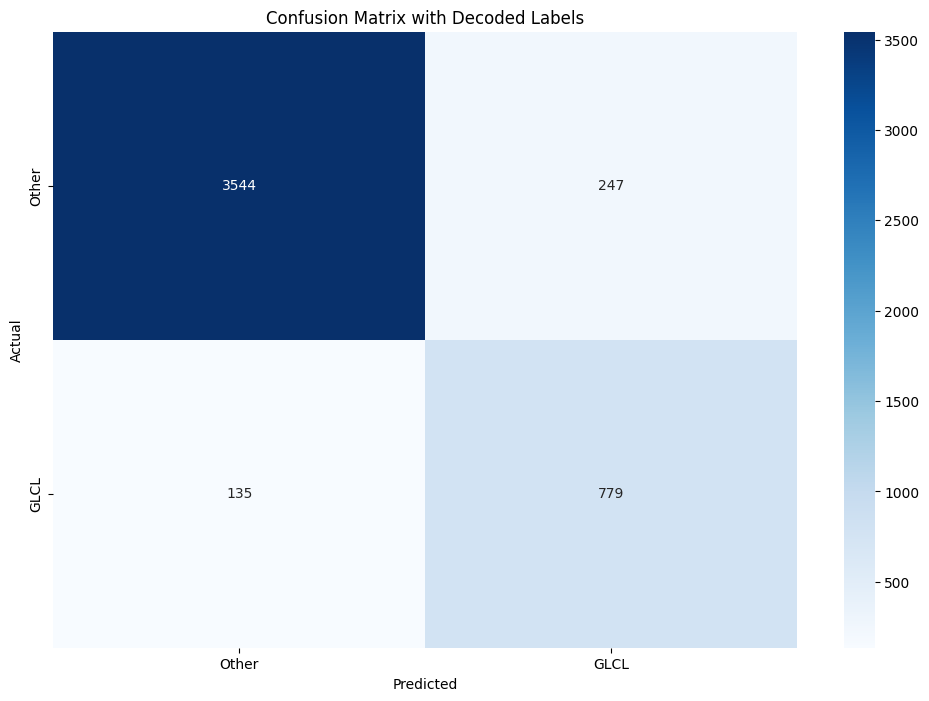

Model saved to xgboost_model_Binary_Classification.pkl


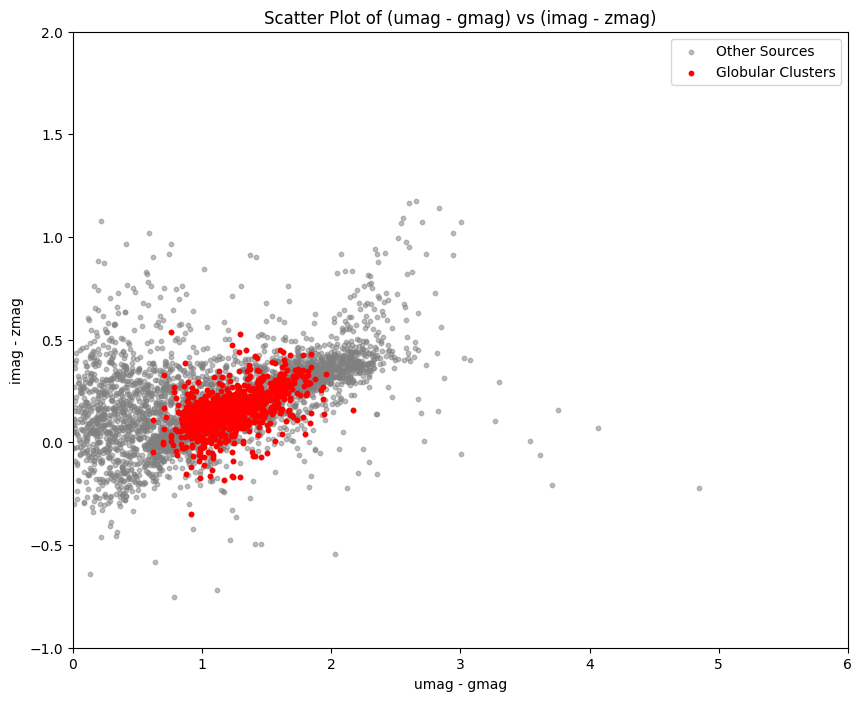

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import xgboost as xgb

# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)



# Important class
important_class = "GLCL"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# Create a mapping for visualization
binary_to_original_mapping = {
    1: important_class,
    0: 'Other'
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train_binary)

# Make predictions on the test set

# y_pred = xgb_classifier.predict(X_test)
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]




# Determine the optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f'Optimal Threshold: {optimal_threshold:.2f}')

# Apply the optimal threshold to the predictions
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the classifier
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Decode the labels using the dictionary
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]


# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model_Binary_Classification.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')


# Scatter plot of (umag - gmag) vs (imag - zmag) with globular clusters highlighted
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    X_test['umag'] - X_test['gmag'],  # Difference between umag and gmag for x-axis
    X_test['imag'] - X_test['zmag'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight globular clusters
plt.scatter(
    X_test['umag'][y_pred == 1] - X_test['gmag'][y_pred == 1],  # x-axis values for predicted globular clusters
    X_test['imag'][y_pred == 1] - X_test['zmag'][y_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()





In [15]:
unlabeled_data_tsne = unlabeled_data[['umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag']]

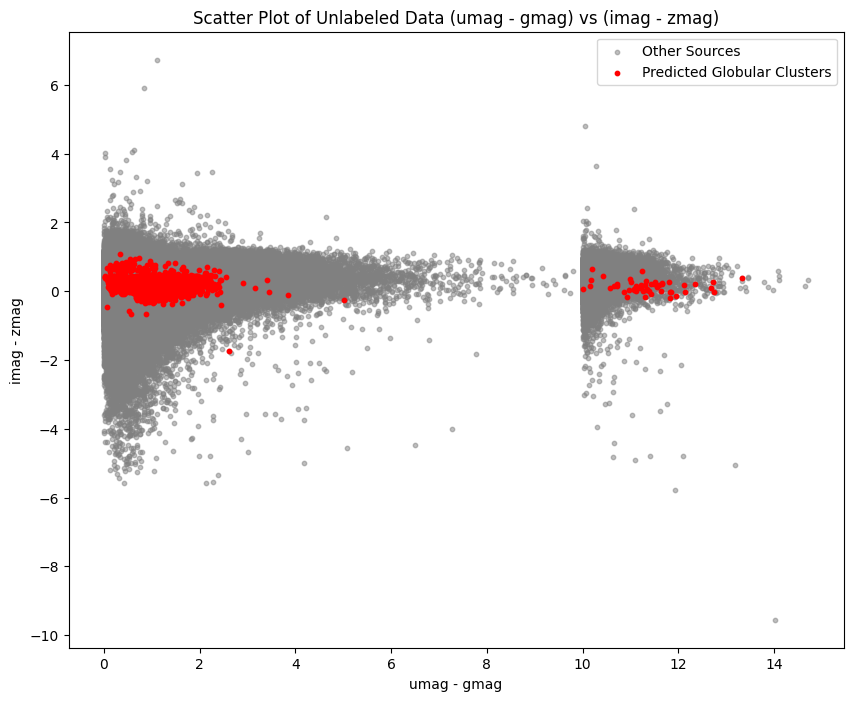

In [16]:
# Make predictions on the unlabeled dataset
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)[:, 1]
unlabeled_data_pred = (unlabeled_data_proba >= optimal_threshold).astype(int)


# Scatter plot for the unlabeled data
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    unlabeled_data['umag'] - unlabeled_data['gmag'],  # Difference between umag and gmag for x-axis
    unlabeled_data['imag'] - unlabeled_data['zmag'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight predicted globular clusters
plt.scatter(
    unlabeled_data['umag'][unlabeled_data_pred == 1] - unlabeled_data['gmag'][unlabeled_data_pred == 1],  # x-axis values for predicted globular clusters
    unlabeled_data['imag'][unlabeled_data_pred == 1] - unlabeled_data['zmag'][unlabeled_data_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Predicted Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
# plt.xlim(0, 6)  # Limit the range for x-axis
# plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

In [17]:
# import pandas as pd
# import numpy as np
# from sklearn.manifold import TSNE
# import umap
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler


# # Select the relevant columns for dimensionality reduction
# features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag']
# unlabeled_data_features = unlabeled_data[features]

# # Standardize the data
# tsne_scaler = StandardScaler()
# unlabeled_data_scaled = tsne_scaler.fit_transform(unlabeled_data_features)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the t-SNE results
# tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# # Apply UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# umap_results = umap_model.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the UMAP results
# umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])

# # Assuming unlabeled_data_pred is already computed
# # unlabeled_data_pred = ... (the binary predictions from your classifier)

# # Visualize t-SNE results
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(tsne_df['TSNE1'][unlabeled_data_pred == 1], tsne_df['TSNE2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2')
# plt.legend()
# plt.title('t-SNE Scatter Plot of Unlabeled Data')
# plt.show()

# # Visualize UMAP results
# plt.figure(figsize=(10, 8))
# plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(umap_df['UMAP1'][unlabeled_data_pred == 1], umap_df['UMAP2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.title('UMAP Scatter Plot of Unlabeled Data')
# plt.show()


In [47]:
unlabeled_data['ik0'].value_counts()

99.0    4473252
Name: ik0, dtype: int64

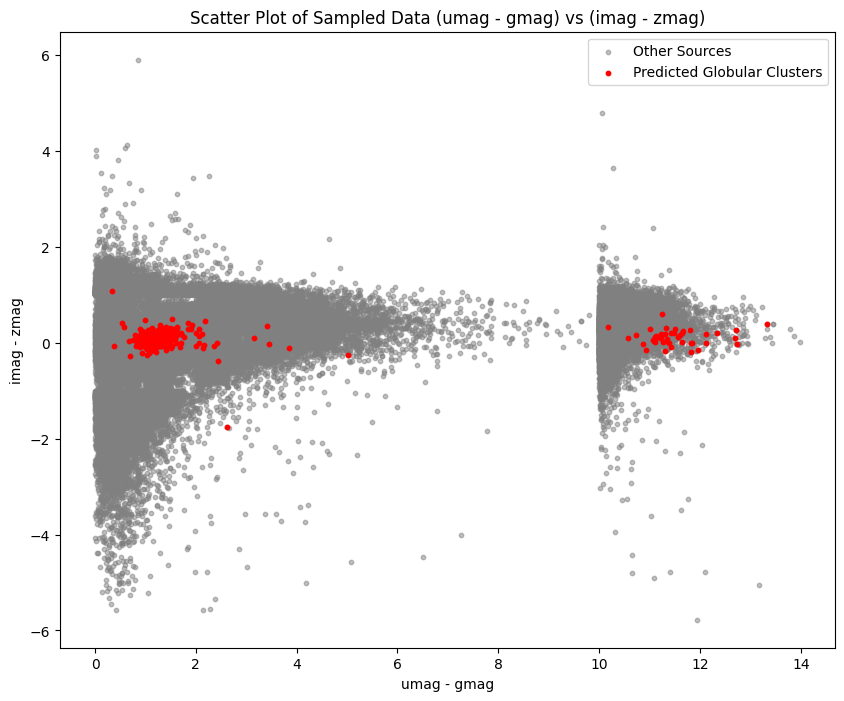

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Calculate the required ranges
umag_gmag_range = (0, 14)
imag_zmag_range = (-6, 6)

# Create new columns for the differences
unlabeled_data['umag_gmag'] = unlabeled_data['umag'] - unlabeled_data['gmag']
unlabeled_data['imag_zmag'] = unlabeled_data['imag'] - unlabeled_data['zmag']

# Define the bins
umag_gmag_bins = np.linspace(umag_gmag_range[0], umag_gmag_range[1], num=15)
imag_zmag_bins = np.linspace(imag_zmag_range[0], imag_zmag_range[1], num=13)

# Assign each row to a bin
unlabeled_data['umag_gmag_bin'] = pd.cut(unlabeled_data['umag_gmag'], bins=umag_gmag_bins, labels=False, include_lowest=True)
unlabeled_data['imag_zmag_bin'] = pd.cut(unlabeled_data['imag_zmag'], bins=imag_zmag_bins, labels=False, include_lowest=True)

# Drop rows that fall outside the defined ranges
unlabeled_data = unlabeled_data.dropna(subset=['umag_gmag_bin', 'imag_zmag_bin'])

# Define the number of samples you want to select per bin
samples_per_bin = 10000 # Adjust this number as needed

# Sample from each bin
sampled_unlabeled_datasets = []
for umag_bin in range(len(umag_gmag_bins)-1):
    for imag_bin in range(len(imag_zmag_bins)-1):
        bin_df = unlabeled_data[(unlabeled_data['umag_gmag_bin'] == umag_bin) & (unlabeled_data['imag_zmag_bin'] == imag_bin)]
        if not bin_df.empty:
            sampled_unlabeled_datasets.append(bin_df.sample(n=min(samples_per_bin, len(bin_df)), replace=False))

# Combine sampled dataframes
sampled_un_data = pd.concat(sampled_unlabeled_datasets)


sampled_un_data = sampled_un_data.drop(columns=['umag_gmag_bin', 'imag_zmag_bin', 'umag_gmag','imag_zmag' ])


# Make predictions on the sampled dataset
sampled_un_data_proba = xgb_classifier.predict_proba(sampled_un_data)[:, 1]
sampled_un_data_pred = (sampled_un_data_proba >= optimal_threshold).astype(int)

# Scatter plot for the sampled data
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    sampled_un_data['umag'] - sampled_un_data['gmag'],  # Difference between umag and gmag for x-axis
    sampled_un_data['imag'] - sampled_un_data['zmag'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight predicted globular clusters
plt.scatter(
    sampled_un_data['umag'][sampled_un_data_pred == 1] - sampled_un_data['gmag'][sampled_un_data_pred == 1],  # x-axis values for predicted globular clusters
    sampled_un_data['imag'][sampled_un_data_pred == 1] - sampled_un_data['zmag'][sampled_un_data_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Predicted Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
# plt.xlim(0, 6)  # Limit the range for x-axis
# plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Sampled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()


In [37]:
sampled_un_data.shape

(110572, 21)

/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


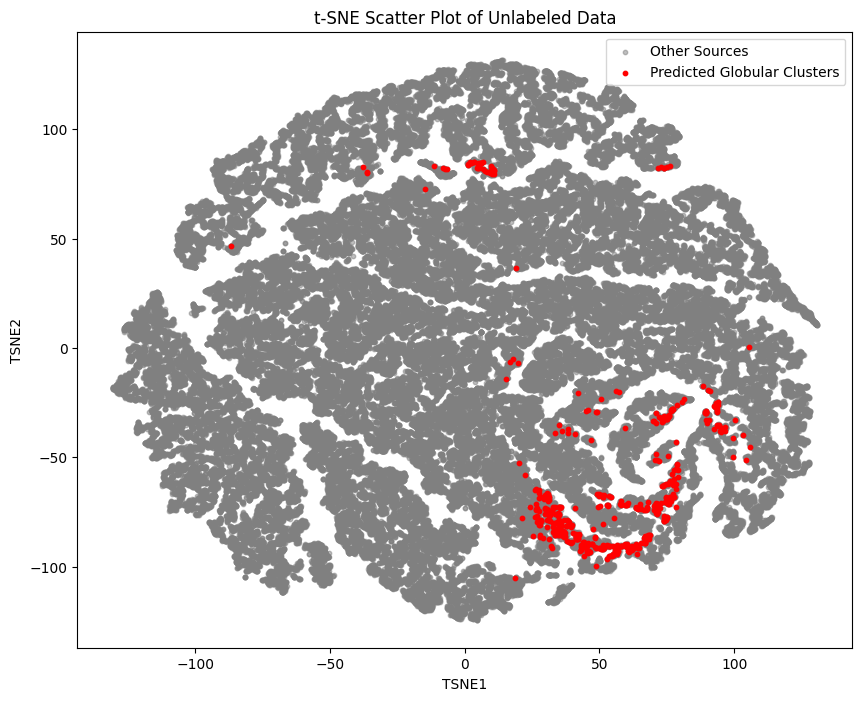

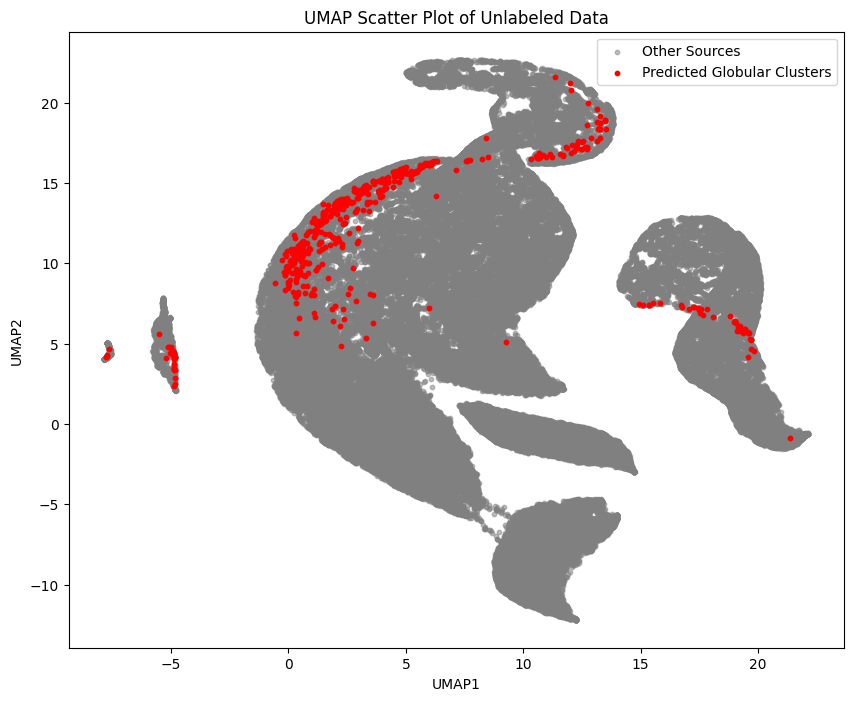

In [43]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Select the relevant columns for dimensionality reduction
features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag']
unlabeled_data_features = sampled_un_data[features]

# Standardize the data
tsne_scaler = StandardScaler()
unlabeled_data_scaled = tsne_scaler.fit_transform(unlabeled_data_features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(unlabeled_data_scaled)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'],  index=sampled_un_data.index)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(unlabeled_data_scaled)

# Create a DataFrame for the UMAP results
umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'],  index=sampled_un_data.index)


# Visualize t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c='gray', s=10, alpha=0.5, label='Other Sources')
plt.scatter(tsne_df['TSNE1'][sampled_un_data_pred == 1], tsne_df['TSNE2'][sampled_un_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend()
plt.title('t-SNE Scatter Plot of Unlabeled Data')
plt.show()

# Visualize UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
plt.scatter(umap_df['UMAP1'][sampled_un_data_pred == 1], umap_df['UMAP2'][sampled_un_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP Scatter Plot of Unlabeled Data')
plt.show()


             UMAP1      UMAP2
2390253  -4.835591   3.957677
2466102  -4.959647   5.110123
2439745  -4.918271   2.444128
2381197  -4.942357   5.090382
2379807  -4.948388   4.795179
2287153  -4.855126   2.929216
2509856  -4.825959   2.161025
2391923  -4.850903   3.377074
2353730  -4.921372   4.191759
2227636  -4.971892   4.515009
3127178   4.822284   1.262859
3627803   6.915324  13.761662
3704003  11.130376   2.362983
3664912  10.919139  17.557358
3982085   9.793269   8.695651
77987     4.042348   8.293473
4325057   3.729695   3.750925
3132406  10.403007  15.491481
90372     9.731492  14.536857
878464    9.708520   9.728377
4249118  16.603611   4.515661
2224903  19.326773   0.485296
3522382  17.348061   6.868555
905853   18.844553   0.821917
4447432  18.669289   7.097267
3134526  19.388878   0.351960
32400    19.906151   8.099507
4248774  19.230455   7.004381
3768772  19.210197   3.392763
1392667  17.328119   9.416032


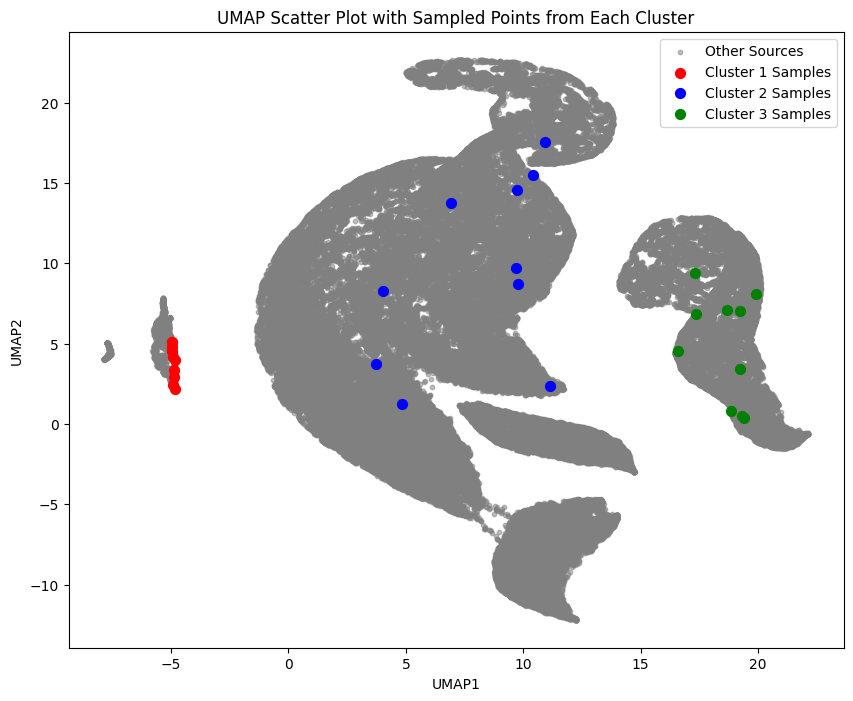

In [44]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Assuming you have already run the previous steps and have tsne_df and umap_df
# Here are the margins for the clusters:
cluster_1_margin = {'umap1': (-5, -2), 'umap2': (1, 8)}
cluster_2_margin = {'umap1': (0, 13), 'umap2': (0, 20)}
cluster_3_margin = {'umap1': (16, 20), 'umap2': (0, 10)}

# Function to filter data based on margins
def filter_data_by_margin(data, margin):
    return data[(data['UMAP1'] >= margin['umap1'][0]) & (data['UMAP1'] <= margin['umap1'][1]) & 
                (data['UMAP2'] >= margin['umap2'][0]) & (data['UMAP2'] <= margin['umap2'][1])]

# Filter the data for each cluster
cluster_1_data = filter_data_by_margin(umap_df, cluster_1_margin)
cluster_2_data = filter_data_by_margin(umap_df, cluster_2_margin)
cluster_3_data = filter_data_by_margin(umap_df, cluster_3_margin)

# Number of samples
n = 10

# Sample 5 samples from each cluster
cluster_1_samples = cluster_1_data.sample(n=n, random_state=42)
cluster_2_samples = cluster_2_data.sample(n=n, random_state=42)
cluster_3_samples = cluster_3_data.sample(n=n, random_state=42)

# Concatenate the samples for easy inspection
selected_samples = pd.concat([cluster_1_samples, cluster_2_samples, cluster_3_samples])

# Display the selected samples
print(selected_samples)

# Visualize the clusters with sampled points
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
plt.scatter(cluster_1_samples['UMAP1'], cluster_1_samples['UMAP2'], c='red', s=50, label='Cluster 1 Samples')
plt.scatter(cluster_2_samples['UMAP1'], cluster_2_samples['UMAP2'], c='blue', s=50, label='Cluster 2 Samples')
plt.scatter(cluster_3_samples['UMAP1'], cluster_3_samples['UMAP2'], c='green', s=50, label='Cluster 3 Samples')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP Scatter Plot with Sampled Points from Each Cluster')
plt.show()


Cluster 1 indices: Int64Index([2602104, 2531408, 2521287, 105398, 2477527], dtype='int64')
Cluster 2 indices: Int64Index([3127178, 3627803, 3704003, 3664912, 3982085], dtype='int64')
Cluster 3 indices: Int64Index([4249118, 2224903, 3522382, 905853, 4447432], dtype='int64')
Original features for Cluster 1 samples:
          elongation       umag       gmag       rmag       imag       zmag  \
2602104         0.0  23.883600  23.235300  22.834999  22.680500  22.746700   
2531408         0.0  24.315500  23.901899  23.402300  22.768600  22.465700   
2521287         0.0  22.815399  20.523001  19.263599  18.583200  18.218800   
105398          0.0  24.471600  23.746700  99.000000  23.531601  23.682199   
2477527         0.0  25.208500  22.507999  21.005699  18.786301  17.770599   

         ksmag     uerr     gerr     rerr  ...     zerr  kserr      iC  \
2602104   99.0  0.03675  0.01320  0.01335  ...  0.06465   99.0  0.2922   
2531408   99.0  0.05370  0.02340  0.02175  ...  0.05220   99.0  0.1

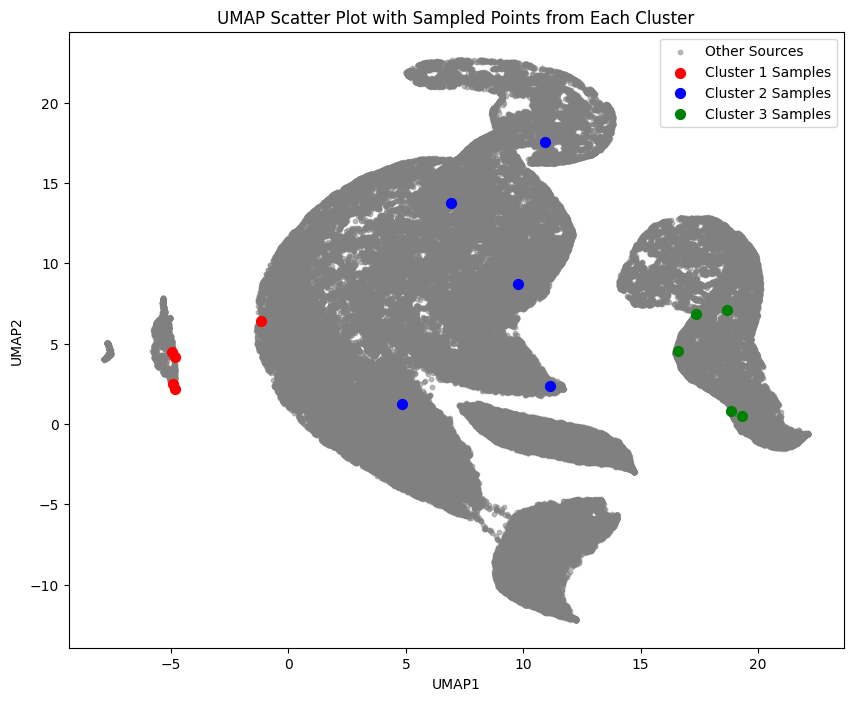

In [45]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Assuming you have already run the previous steps and have tsne_df and umap_df
# Here are the margins for the clusters:
cluster_1_margin = {'umap1': (-5, -1), 'umap2': (1, 8)}
cluster_2_margin = {'umap1': (0, 13), 'umap2': (0, 20)}
cluster_3_margin = {'umap1': (16, 20), 'umap2': (0, 10)}

# Function to filter data based on margins
def filter_data_by_margin(data, margin):
    return data[(data['UMAP1'] >= margin['umap1'][0]) & (data['UMAP1'] <= margin['umap1'][1]) & 
                (data['UMAP2'] >= margin['umap2'][0]) & (data['UMAP2'] <= margin['umap2'][1])]

# Filter the data for each cluster
cluster_1_data = filter_data_by_margin(umap_df, cluster_1_margin)
cluster_2_data = filter_data_by_margin(umap_df, cluster_2_margin)
cluster_3_data = filter_data_by_margin(umap_df, cluster_3_margin)

# Sample 5 samples from each cluster
cluster_1_samples = cluster_1_data.sample(n=5, random_state=42)
cluster_2_samples = cluster_2_data.sample(n=5, random_state=42)
cluster_3_samples = cluster_3_data.sample(n=5, random_state=42)

# Get the indices of the selected samples
cluster_1_indices = cluster_1_samples.index
cluster_2_indices = cluster_2_samples.index
cluster_3_indices = cluster_3_samples.index

# Concatenate the samples for easy inspection
selected_samples = pd.concat([cluster_1_samples, cluster_2_samples, cluster_3_samples])

# Display the indices of the selected samples
print("Cluster 1 indices:", cluster_1_indices)
print("Cluster 2 indices:", cluster_2_indices)
print("Cluster 3 indices:", cluster_3_indices)

# Retrieve the original features using the indices
original_features_cluster_1 = sampled_un_data.loc[cluster_1_indices]
original_features_cluster_2 = sampled_un_data.loc[cluster_2_indices]
original_features_cluster_3 = sampled_un_data.loc[cluster_3_indices]

# Display the original features for the selected samples
print("Original features for Cluster 1 samples:\n", original_features_cluster_1)
print("Original features for Cluster 2 samples:\n", original_features_cluster_2)
print("Original features for Cluster 3 samples:\n", original_features_cluster_3)

# Visualize the clusters with sampled points
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
plt.scatter(cluster_1_samples['UMAP1'], cluster_1_samples['UMAP2'], c='red', s=50, label='Cluster 1 Samples')
plt.scatter(cluster_2_samples['UMAP1'], cluster_2_samples['UMAP2'], c='blue', s=50, label='Cluster 2 Samples')
plt.scatter(cluster_3_samples['UMAP1'], cluster_3_samples['UMAP2'], c='green', s=50, label='Cluster 3 Samples')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP Scatter Plot with Sampled Points from Each Cluster')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store precision, recall, accuracy, and F1 score for each label
precisions = []
recalls = []
f1_scores = []

print(binary_to_original_mapping.items())

# Calculate precision, recall, accuracy, and F1 score for each label
for index, label in binary_to_original_mapping.items():  # Swap label and index
    print(f"Processing index: {index}, label: {label}")
    
    if index == 1:
        print("Index is 1")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[1, 1]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[0, 1]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[1, 0]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[0, 0]
    elif index == 0:
        print("Index is 0")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[0, 0]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[1, 0]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[0, 1]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[1, 1]
    else:
        assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
        print("Index is neither 0 nor 1, skipping this index")
        continue  # Skip labels not covered in the binary mapping

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each label
labels = list(binary_to_original_mapping.values())
x = np.arange(len(labels))

bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

########### Training on Random Forest
############
############
###########
###########

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()


# Feature importance
feature_importances = rf_classifier.feature_importances_
features = X_train.columns

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest Classifier')
plt.show()

# Save the trained model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [ ]:
#  Get the index of the label 'GLCL'
glcl_index = label_mapping["GLCL"]

# Extract the row and column corresponding to 'GLCL' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'GLCL'
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
num_classes = conf_matrix.shape[0]

# Initialize lists to store precision, recall, and f1 score for each label
precisions = []
recalls = []
f1_scores = []



# Calculate precision, recall, and f1 score for each class
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each class
labels = list(label_mapping.keys())
x = np.arange(len(labels))
bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

######## Training on random Forest by Binarization #######

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Important class
important_class = "GLCL"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# Create a mapping for visualization
binary_to_original_mapping = {
    1: important_class,
    0: 'Other'
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train_binary)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Decode the labels using the dictionary
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'RandomForest_model_Binary_Classification.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store precision, recall, accuracy, and F1 score for each label
precisions = []
recalls = []
f1_scores = []

print(binary_to_original_mapping.items())

# Calculate precision, recall, accuracy, and F1 score for each label
for index, label in binary_to_original_mapping.items():  # Swap label and index
    print(f"Processing index: {index}, label: {label}")
    
    if index == 1:
        print("Index is 1")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[1, 1]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[0, 1]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[1, 0]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[0, 0]
    elif index == 0:
        print("Index is 0")
        # True Positives (TP): Diagonal element for the current label
        tp = conf_matrix[0, 0]

        # False Positives (FP): Sum of the column for the current label excluding the diagonal element
        fp = conf_matrix[1, 0]

        # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
        fn = conf_matrix[0, 1]

        # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
        tn = conf_matrix[1, 1]
    else:
        assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
        print("Index is neither 0 nor 1, skipping this index")
        continue  # Skip labels not covered in the binary mapping

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f1_scores.append(f1_score)

# Plot Precision, Recall, and F1 Score for each label
labels = list(binary_to_original_mapping.values())
x = np.arange(len(labels))

bar_width = 0.3

plt.figure(figsize=(16, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()